3D SLAM with Lie Group SE(3), Barfoot.

Transformation Matrix 

At time k,
 
$T_{k} = \begin{bmatrix} {}^{i}C^{v_{k}} &  - {}^{i}C^{v_{k}} {}^{i}r^{v_{k}} \\ 0_{1x3} & 1 \end{bmatrix} \in SE(3)$

where <br>
$^{i}C^{v_{k}}$ is rotation matrix from inertial frame to vehicl (body) frame at time k <br>
$^{i}r^{v_{k}}$ is translation vector from origin of inertial frame to the orgin point of vehicle frame at time k


Error Cost Function

At time k,

$e_{k} = \sum_{j} (y_{k} - T_{k} * p_{j})$

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import casadi as ca
import BF_PCA
import time
import random

import sys
sys.path.insert(0, '../')
from pyecca.lie import se3, so3, matrix_lie_group

#For plotting
nFig = 0
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.text import Annotation

In [3]:
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 
    
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

setattr(Axes3D, 'arrow3D', _arrow3D)

class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)

def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)

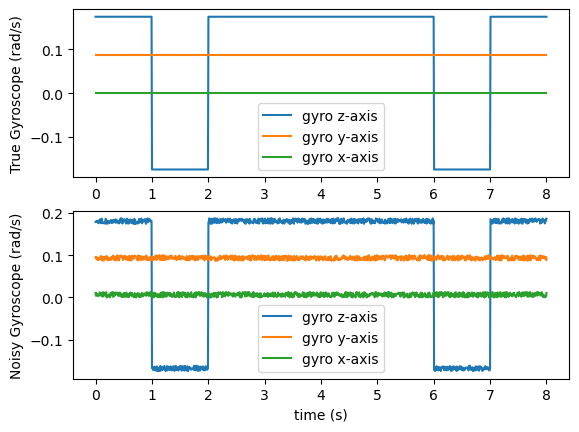

In [18]:
#------------------------
# Initialize Inputs

#Translational Input
u = np.array([1,2,3,1,3,4,1,1])

#Time array 
dt = 1
tf = len(u) * dt

#True Rate for Yaw, Pitch, Roll
sampRate = 128 #Hz

yaw_rate1 = 10 * np.pi/180
yaw_rate2 = -yaw_rate1
pitch_rate = 5 * np.pi/180
roll_rate = 0

chunk = np.ones(sampRate)
flipflop = np.random.randint(2, size=len(u))
gyro_Z_true = np.array([])
for i in flipflop:
    if i:
        gyro_Z_true=np.append(gyro_Z_true,chunk*yaw_rate1)
    else:
        gyro_Z_true=np.append(gyro_Z_true,chunk*yaw_rate2)


gyro_Y_true = np.ones(len(u)*sampRate) * pitch_rate
gyro_X_true = np.ones(len(u)*sampRate) * roll_rate

#Noisy reading from gyroscope
k = 13e-9
noise = k*np.asarray(random.sample(range(0,1000000),len(u)*sampRate)) 
gyro_Z = gyro_Z_true + noise
noise = k*np.asarray(random.sample(range(0,1000000),len(u)*sampRate)) 
gyro_Y = gyro_Y_true + noise
noise = k*np.asarray(random.sample(range(0,1000000),len(u)*sampRate)) 
gyro_X = gyro_X_true + noise

#Plot gyroscope data
t_vect = np.linspace(0,tf,len(u)*sampRate)
plt.figure(nFig)
plt.subplot(2, 1, 1)
plt.plot(t_vect, gyro_Z_true, label="gyro z-axis")
plt.plot(t_vect, gyro_Y_true, label="gyro y-axis")
plt.plot(t_vect, gyro_X_true, label="gyro x-axis")
plt.ylabel('True Gyroscope (rad/s)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_vect, gyro_Z, label="gyro z-axis")
plt.plot(t_vect, gyro_Y, label="gyro y-axis")
plt.plot(t_vect, gyro_X, label="gyro x-axis")
plt.xlabel('time (s)')
plt.ylabel('Noisy Gyroscope (rad/s)')
plt.legend()

#Average the gyroscope data for each time step, dt
gyro_X_avg = []
gyro_Y_avg = []
gyro_Z_avg = []

t_vect = np.arange(0,tf,dt)
for k, tk in enumerate(t_vect):

    gyro_X_sampled = np.array(gyro_X[k*sampRate:(k+1)*sampRate])
    gyro_X_avg.append(np.average(gyro_X_sampled.astype(float) ,axis=0))
    
    gyro_Y_sampled = np.array(gyro_Y[k*sampRate:(k+1)*sampRate])
    gyro_Y_avg.append(np.average(gyro_Y_sampled.astype(float) ,axis=0))
    
    gyro_Z_sampled = np.array(gyro_Z[k*sampRate:(k+1)*sampRate])
    gyro_Z_avg.append(np.average(gyro_Z_sampled.astype(float) ,axis=0))

In [28]:
t0 = time.time()

#------------------------
# Define constant

deg_to_rad = np.pi / 180

noise={
    'odom_std': 0.0,
    'x_std': 0.0,
    'y_std': 0.0,
    'z_std': 0.0,
    'odom_bx_bias': 0.0,
    'odom_by_bias': 0.0,
    'odom_bz_bias': 0.0
}

#------------------------
# Initialize states
        
#Define landmarks and coresponding weight
landmarks = np.array([[1,1,0],
                     [3,4,0],
                     [6,5,0],
                     [3,8,0],
                     [2,6,0]])
weight = np.array([1,
                   1,
                   1,
                   1,
                   1])

#Define true state variable x described in inertial frame
x0 = np.array([0.,0.,0.]);
x_prev = x0;
Rot0 = np.identity(3)

#Define estimated state wrt inetial frame
xh = np.array([x0])
Roth = Rot0
Rotk = Rot0

SE3 = se3._SE3()

J = ca.SX.zeros(1,1)

hist = {'x': [x0],
        'y': [],
        'R':  [Rot0],
        'T': [],
        'assoc':[],
       'Frame': ['inertial']};
Top_allbody = []
yk_allbody = []
assoc_allbody = []

Top_allbody.append(np.eye(4))


#------------------------
#Begin Simulation

yaw_prev = 0
pitch_prev = 0
roll_prev = 0

for k, tk in enumerate(t_vect):
    
    # !!! Move then measure !!!
    
    #Assign Rotation and translation Input
    # !!! rotate then translate !!!
    
    #Rotation Matrix (True)
    dyaw = gyro_Z_true[k * sampRate] * dt
    dpitch = gyro_Y_true[k * sampRate] * dt
    droll = gyro_X_true[k * sampRate] * dt
    
    Rot_prev2current = BF_PCA.euler2rot(dyaw, dpitch, droll) #previous body to current body
    Rotk = Rotk@Rot_prev2current #inertial frame to current body frame
    
    #Translate (True)
    uk = u[k]
    uTrans_k = Rotk@np.array([uk, 0, 0]).T
    
    #Update State variables: xk = r_vk_i is in inertial frame (barfoot)
    xk = x_prev + uTrans_k; 
    
    #Measure landmarks
    yk = BF_PCA.measure_landmark(Rotk, xk, landmarks, noise=None, range_max=1000)
    yk_allbody.append(yk)
    
    #Transformation Matrix (True)
    Tk = np.vstack([np.hstack([Rotk.T, np.matmul(-Rotk.T,xk).reshape(3,1)]), np.array([[0, 0, 0, 1]])])
    
    #Define symbolic perturbation of T
    trans_sym = ca.vertcat(ca.SX.sym('u_'+str(k)), ca.SX.sym('v_'+str(k)), ca.SX.sym('w_'+str(k)))
    angles_sym = ca.vertcat(ca.SX.sym('omega1_'+str(k)), ca.SX.sym('omega2_'+str(k)), ca.SX.sym('omega3_'+str(k)))
    epsilon = ca.vertcat(trans_sym, angles_sym)
    if k == 0:
        epsilon_all = epsilon
    else:
        epsilon_all = ca.vertcat(epsilon_all, epsilon)

    #Associate landmarks index to measurement observed using maximum likelihood
    assoc = [ BF_PCA.data_association(xk, yi, landmarks, Rotk) for yi in yk ]
    assoc_allbody.append(assoc)
    
    #Re-assign previous state
    x_prev = xk
                          
    # Initialize Operating Point "Top"
    useGyroData = False
    
    if k == 0:
        algopt = np.array([0,0,0,0,0,0])
        Top = SE3.exp(SE3.wedge(algopt)) 
        
    if useGyroData:
        #Use noisy gyroscope data as initial guess for lie algebra
        dyaw = gyro_Z_avg[k] * dt
        dpitch = gyro_Y_avg[k] * dt
        droll = gyro_X_avg[k] * dt
        
        # print("yaw pitch roll",dyaw, dpitch, droll)
        Rop_prev2current = BF_PCA.euler2rot(dyaw, dpitch, droll)
        Top_prev2current = np.vstack([np.hstack([Rop_prev2current.T, np.zeros([3,1])]), np.array([[0, 0, 0, 1]])])
        Top = Top_prev2current@Top
        print("expected", Top_prev2current)
        
        # print("before adding gyro", algopt)
        algopt = SE3.vee(SE3.log(Top))
        # print("after adding gyro", algopt)

        
    algoptprev = None
    
    #----- Point Cloud Alignment, iterative optimization for each time step k -------
    
    """
    CasADi Optimization method
    """
#     counter = 0
#     while algoptprev is None or ca.norm_2(algopt-algoptprev)>1e-8:  
        
#         #cost function (Barfoot 8.95)
#         J = BF_PCA.build_cost_barfoot(Top=Top , 
#                                       p=landmarks, 
#                                       y=yk, 
#                                       assoc=assoc,
#                                       weight=weight,
#                                       epsilon=epsilon)
        
#         # Symbols/expressions
#         nlp = {}                 # NLP declaration
#         nlp['x'] = epsilon       # decision vars
#         nlp['f'] = J             # objective
#         nlp['g'] = 0             # constraints
        
#         # Create solver instance
#         opts = {'ipopt.print_level':0, 'print_time':0, 'ipopt.sb': 'yes'}
#         F = ca.nlpsol('F','ipopt',nlp, opts);
        
#         # Solve the problem using a guess
#         # This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
#         x_input = np.zeros(6)
#         optim = F(x0=x_input)
        
#         algoptprev = algopt
#         algopt = optim['x']
#         Top = SE3.exp(SE3.wedge(algopt))@Top
#         counter +=1

    #--------------------------------------
        
    """
    Barfoot's method
    """                                      
    counter = 0
    while algoptprev is None or ca.norm_2(algopt-algoptprev)>5e-14:    
        algoptprev = algopt
        algopt = BF_PCA.barfoot_solve(Top,landmarks,yk,assoc,weight)
        Top = SE3.exp(SE3.wedge(algopt))@Top
        counter +=1
    
    #--------------------------------------
   
    # print("Final algopt ", algopt)
    print("real", ca.inv(Top_allbody[-1])@Top)
    print("At iteration #", k , "Barfoot took ", counter, " iterations til converge\n\n")
    Top_allbody.append(Top)
    
    
#     #----- Point Cloud Tracking, optimization for all time -------
#     J = ca.SX.zeros(1,1)
#     for i in range(k+1):
#         #Update cost function (Barfoot 8.95)
#         J += BF_PCA.build_cost_barfoot(Top=Top_allbody[i] , 
#                                        p=landmarks, 
#                                        y=yk_allbody[i], 
#                                        assoc=assoc_allbody[i], 
#                                        epsilon=epsilon)


    
#     # Non-linear programming
#     #   for point cloud alignment problem, we are solving for "T" only which include of:
#     # - rotation matrix from inertial-frame to vehicle-frame
#     # - translation vector describing the vehicle's pose in inertial-frame

#     # Symbols/expressions
#     nlp = {}                 # NLP declaration
#     nlp['x'] = epsilon_all   # decision vars
#     nlp['f'] = J             # objective
#     nlp['g'] = 0             # constraints

#     # Create solver instance
#     opts = {'ipopt.print_level':0, 'print_time':0, 'ipopt.sb': 'yes'}
#     F = ca.nlpsol('F','ipopt',nlp, opts);
    
#     # Solve the problem using a guess
#     # This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
#     eps = 1e-20
#     x_input = np.ones(6*(k+1)) * eps
#     optim = F(x0=x_input)

#     for i in range(k+1):
#         That = SE3.exp(SE3.wedge(optim['x'][(i*6):(i*6)+6]))@Top_allbody[i]
#         Top_allbody[i] = That
        
#     #------------------------------------------------

    #Append "true state" history
    hist['x'].append(xk)
    hist['R'].append(Rotk)
    hist['T'].append(Tk)
    hist['Frame'].append(k)
    for yi in yk:
        hist['y'].append(np.hstack([yi, k]))      # History of measurements recorded at each time step
    for i in range(len(assoc)):
        hist['assoc'].append(np.hstack(['p'+str(assoc[i]), 'x'+str(k)]))
 
for key in hist.keys():
    hist[key] = np.array(hist[key])

tf =  time.time() - t0
print('runtime [s]: ', tf)

real @1=0, 
[[0.98106, 0.173648, -0.0858317, -1], 
 [-0.172987, 0.984808, 0.0151344, 3.12174e-15], 
 [0.0871557, 3.9219e-17, 0.996195, -7.65409e-17], 
 [@1, @1, @1, 1]]
At iteration # 0 Barfoot took  6  iterations til converge


real 
[[0.981741, -0.172287, -0.0806351, -1.92121], 
 [0.169113, 0.984582, -0.0447183, -0.514367], 
 [0.0870962, 0.0302654, 0.99574, 0.0805955], 
 [7.9079e-17, -2.93384e-17, -3.42211e-18, 1]]
At iteration # 1 Barfoot took  6  iterations til converge


real 
[[0.981728, 0.169772, -0.0859494, -2.96745], 
 [-0.16643, 0.985039, 0.0447123, 0.514939], 
 [0.0922544, -0.0295907, 0.995296, 0.247837], 
 [-3.21946e-16, -8.44547e-17, 1.23603e-16, 1]]
At iteration # 2 Barfoot took  6  iterations til converge


real 
[[0.981728, 0.169772, -0.0859494, -1.06495], 
 [-0.16643, 0.985039, 0.0447123, 0.85832], 
 [0.0922544, -0.0295907, 0.995296, -0.264605], 
 [-1.22277e-16, -1.71423e-16, 3.32615e-16, 1]]
At iteration # 3 Barfoot took  6  iterations til converge


real 
[[0.981728,

In [26]:
np.array([[Top[0,3]],[Top[1,3]],[Top[2,3]]])

array([[SX(0)],
       [SX(0)],
       [SX(0)]], dtype=object)

In [23]:
# # #Compare
# for i in range(len(Top_allbody)):
#     print("iteration ", i)
#     print("diff: ", ca.SX(hist["T"][1]) - Top_allbody[1], "\n")

In [20]:
# 3D plot
%matplotlib qt
nFig += 1
fig = plt.figure(nFig)
ax = fig.add_subplot(111, projection='3d')

#Plot true state
ax.plot(hist['x'][:, 0] , hist['x'][: , 1], hist['x'][:, 2], label="True State")
ax.set_title("Point Cloud Alignment")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#Plot body-frames (arrow is assumed to be equivalent to x-axis of the body frame)
textEnable = True
Rotate_x2y = BF_PCA.euler2rot(np.pi/2, 0 ,0)
Rotate_x2z = BF_PCA.euler2rot(0, -np.pi/2, 0)

x = hist['x']
Rot = hist['R']
for i in range(len(x)):
    if textEnable:
        ax.annotate3D(hist['Frame'][i], x[i],
              xytext=x[i,:2]+[-1,-1],
              textcoords='offset points',
              bbox=dict(boxstyle="round", fc="lightyellow"))

    
    x_axis = np.matmul(Rot[i] , [1, 0 , 0])
    y_axis = Rotate_x2y@np.matmul(Rot[i] , [1 , 0 , 0])
    # z_axis = Rotate_x2z@np.matmul(Rot[i] , [0.05 , 0, 0])
    ax.arrow3D(x[i,0] , x[i, 1] , x[i, 2], x_axis[0] , x_axis[1], x_axis[2],mutation_scale=10, ec ='red',fc='red')
    ax.arrow3D(x[i,0] , x[i, 1] , x[i, 2], y_axis[0] , y_axis[1], y_axis[2],mutation_scale=10, ec ='green',fc='green')
    # ax.arrow3D(x[i,0] , x[i, 1] , x[i, 2], z_axis[0] , z_axis[1], z_axis[2],mutation_scale=10, ec ='blue',fc='blue')

#Plot Landmarks
for m in landmarks:
    ax.scatter(m[0],m[1],m[2],s=30, marker='o', color='black')

#Plot measurement
# for arr in hist['y']:
#     zbody = arr[:3]
#     i  = int(arr[-1])
#     zinertial = np.matmul(Rot[i+1] , zbody)
#     ax.arrow3D(x[i + 1, 0] , x[i + 1, 1] , x[i + 1, 2], zinertial[0] , zinertial[1], zinertial[2],mutation_scale=10, ec ='black',fc='black')

ax.legend()

In [21]:
# 2D plot
nFig += 1
fig = plt.figure(nFig)

#Plot true vs. estimated state
plt.plot(hist['x'][:, 0] , hist['x'][: , 1], label="True State")
plt.title("Point Cloud Alignment (2D Projection)")
plt.xlabel('x')
plt.ylabel('y')

textEnable = True
Rotate_x2y = BF_PCA.euler2rot(np.pi/2, 0 ,0)

#Plot body-frames (arrow is assumed to be equivalent to x-axis of the body frame)
x = hist['x']
Rot = hist['R']
for i in range(len(x)):
    
    if textEnable:
        plt.text(x[i,0] + 0.15 , x[i, 1] + 0.15, hist['Frame'][i])
    
    x_axis = np.matmul(Rot[i] , [0.5 , 0 , 0])
    y_axis = Rotate_x2y@np.matmul(Rot[i] , [0.5 , 0 , 0])
    plt.arrow(x[i,0] , x[i, 1] , x_axis[0] , x_axis[1], width=0.01, length_includes_head=True, head_width=0.1,head_length=0.1)
    plt.arrow(x[i,0] , x[i, 1] , y_axis[0] , y_axis[1], width=0.01, length_includes_head=True, head_width=0.1,head_length=0.1)
    
#Plot Landmarks
for m in landmarks:
    plt.plot(m[0],m[1],'ro')

    
#Plot measurement
# for arr in hist['y']:
#     zi = arr[:3]
#     i  = int(arr[-1])
#     plt.arrow(hist['x'][i + 1, 0] , hist['x'][i + 1, 1], np.matmul(Rot[i+1] , zi)[0] ,np.matmul(Rot[i+1] , zi)[1], width=0.06, head_width=0.1, head_length=0.1, length_includes_head=True)
    
plt.legend()